# Example for analysis of NanoAOD samples

In this example we don't need any pre-processing of NanoAOD samples and can still use several tools of the tW_scattering repository.

- Get the proper normalization for samples
- Categorize different samples into process categories
- Use coffea processors for the map-reduce step
- Make "nice" histograms


In [1]:
%load_ext autoreload
%autoreload 2

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import processor, hist

from processor.nano_analysis import nano_analysis
from Tools.config_helpers import loadConfig
from klepto.archives import dir_archive

In [3]:
from klepto.archives import dir_archive
from processor.std_acumulators import desired_output, add_processes_to_output

from Tools.helpers import get_samples
from Tools.config_helpers import redirector_ucsd, redirector_fnal
from Tools.nano_mapping import make_fileset, nano_mapping

overwrite = True

# load the config and the cache
cfg = loadConfig()

cacheName = 'nano_analysis'
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)

year = 2018

# get a python dictionary of all NanoAOD samples
# The samples definitions can be found in data/samples.yaml
samples = get_samples()

# make a fileset, taking the definitions in Tools/nano_mapping.py
fileset = make_fileset(['DY', 'TTZ', 'top'], samples, redirector=redirector_fnal, small=True)

# in order for cutflows to work we need to add every process to the output accumulator
add_processes_to_output(fileset, desired_output)

histograms = sorted(list(desired_output.keys()))

exe_args = {
    'workers': 16,
    'function_args': {'flatten': False},
     "schema": NanoAODSchema,
}
exe = processor.futures_executor

if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    print ("I'm running now")

    output = processor.run_uproot_job(
        fileset,
        "Events",
        nano_analysis(year=year, variations=[], accumulator=desired_output),
        exe,
        exe_args,
        chunksize=250000,
    )

    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()

NameError: name 'num' is not defined

In [50]:
output['totalEvents']['all']/1e6

3.786047

Full fileset is 180M events, and that's basically just DY and ttbar.

In [51]:
# import the plotting libararies: matplotlib and mplhep

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)


# load the functions to make a nice plot from the output histograms
# and the scale_and_merge function that scales the individual histograms
# to match the physical cross section

from plots.helpers import makePlot, scale_and_merge

# define a few axes that we can use to rebin our output histograms

N_bins         = hist.Bin('multiplicity', r'$N$', 10, -0.5, 9.5)
N_bins_red     = hist.Bin('multiplicity', r'$N$', 5, -0.5, 4.5)
pt_bins        = hist.Bin('pt', r'$p_{T}\ (GeV)$', 30, 0, 300)
pt_bins_coarse = hist.Bin('pt', r'$p_{T}\ (GeV)$', 10, 0, 300)
eta_bins       = hist.Bin('eta', r'$\eta $', 25, -5.0, 5.0)
phi_bins       = hist.Bin('phi', r'$\phi $', 16, -3.2, 3.2)


# define nicer labels and colors

my_labels = {
    nano_mapping['TTW'][0]: 'ttW',
    nano_mapping['TTZ'][0]: 'ttZ',
    nano_mapping['DY'][0]: 'DY',
    nano_mapping['top'][0]: 't/tt+jets',
}

my_colors = {
    nano_mapping['TTW'][0]: '#8AC926',
    nano_mapping['TTZ'][0]: '#FFCA3A',
    nano_mapping['DY'][0]: '#6A4C93',
    nano_mapping['top'][0]: '#1982C4',
}



Data: 0 MC: 888.86


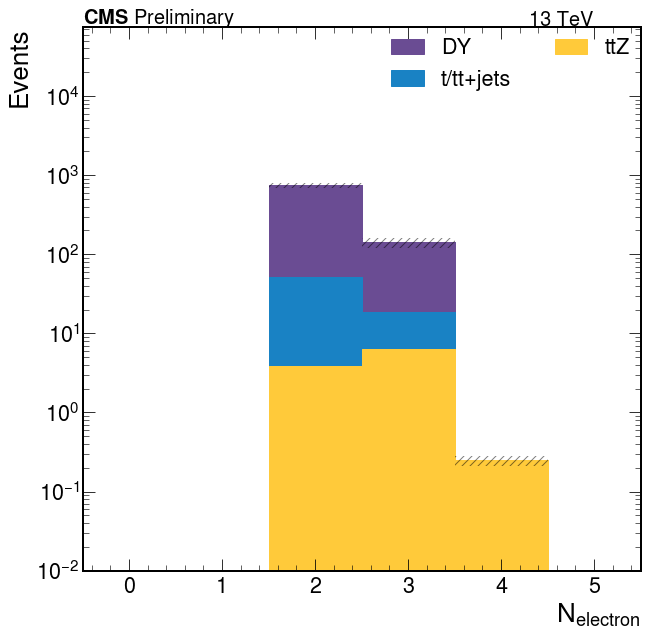

In [52]:
# take the N_ele histogram out of the output, apply the x-secs from samples to the samples in fileset
# then merge the histograms into the categories defined in nano_mapping

my_hist = scale_and_merge(output['N_ele'], samples, fileset, nano_mapping)

# Now make a nice plot of the electron multiplicity.
# You can have a look at all the "magic" (and hard coded monstrosities) that happens in makePlot
# in plots/helpers.py

makePlot(my_hist, None, 'multiplicity',
         data_sel=None,
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{electron}$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
        )

In [ ]:
my_hist = scale_and_merge(output['electron_flips'], samples, fileset, nano_mapping)

makePlot(my_hist, None, 'multiplicity',
         data_sel=None,
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{electron}$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
        )

Data: 0 MC: 877.54


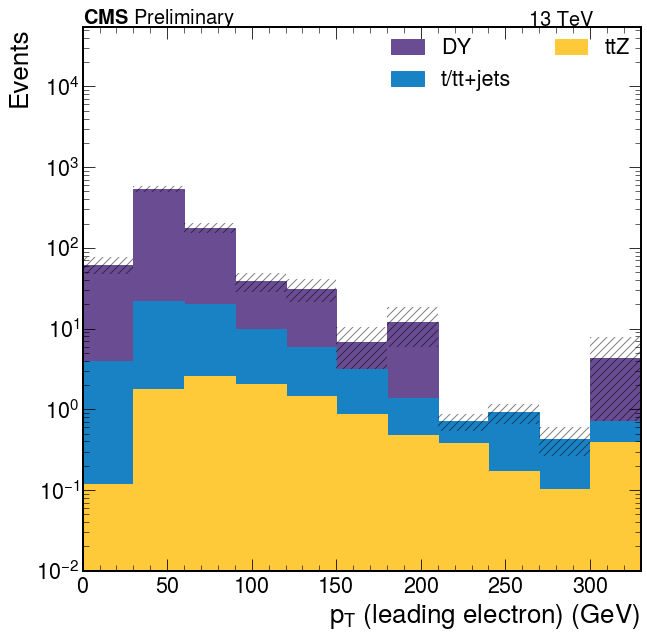

In [76]:
my_hist = scale_and_merge(output['electron'], samples, fileset, nano_mapping)

makePlot(my_hist, None, 'pt',
         data_sel=None,
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}\ (leading\ electron)\ (GeV)$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
        )

Data: 0 MC: 510.4


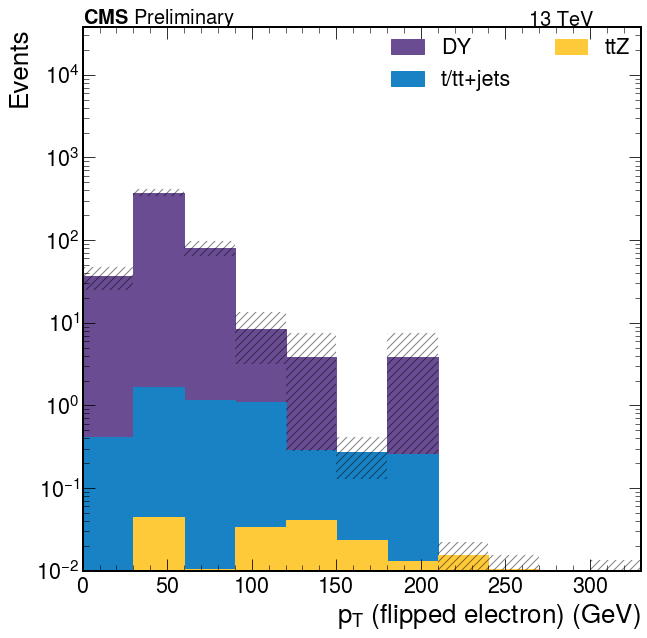

In [77]:
my_hist = scale_and_merge(output['flipped_electron'], samples, fileset, nano_mapping)

makePlot(my_hist, None, 'pt',
         data_sel=None,
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}\ (flipped\ electron)\ (GeV)$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
        )

Data: 0 MC: 877.54


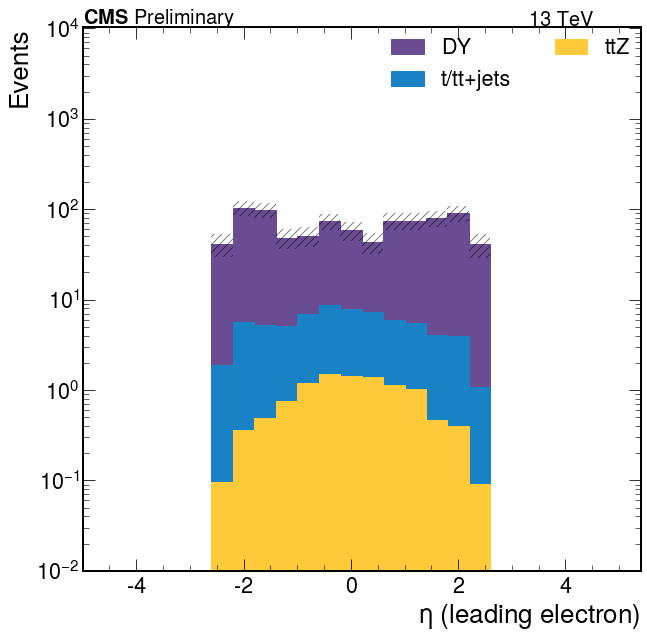

In [79]:
my_hist = scale_and_merge(output['electron'], samples, fileset, nano_mapping)

makePlot(my_hist, None, 'eta',
         data_sel=None,
         bins=eta_bins, log=True, normalize=False, axis_label=r'$\eta\ (leading\ electron)$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
        )

Data: 0 MC: 510.4


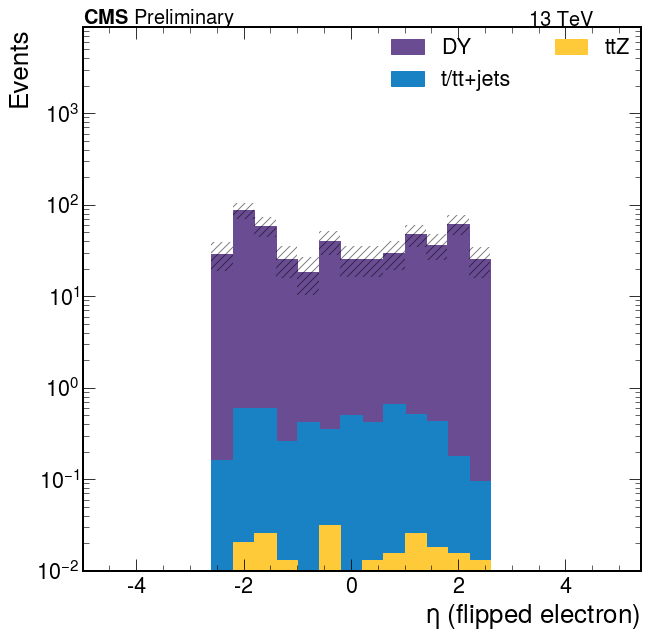

In [80]:
my_hist = scale_and_merge(output['flipped_electron'], samples, fileset, nano_mapping)

makePlot(my_hist, None, 'eta',
         data_sel=None,
         bins=eta_bins, log=True, normalize=False, axis_label=r'$\eta\ (flipped\ electron)$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
        )

Data: 0 MC: 888.86


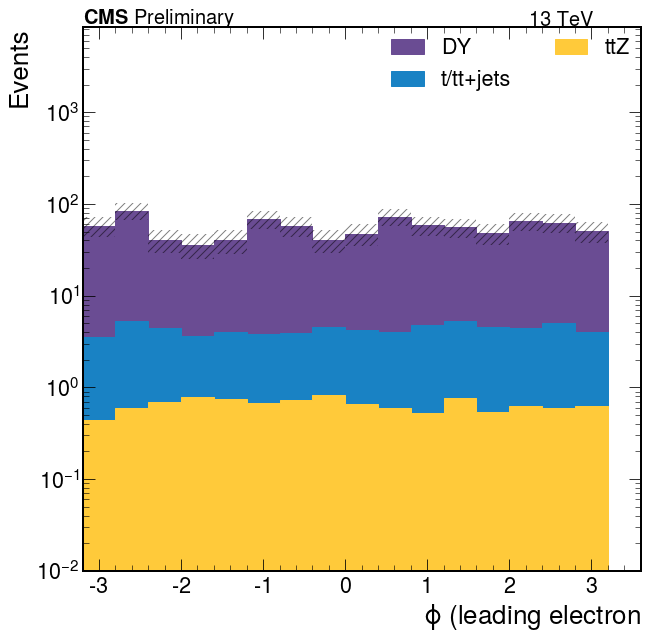

In [67]:
my_hist = scale_and_merge(output['electron'], samples, fileset, nano_mapping)

makePlot(my_hist, None, 'phi',
         data_sel=None,
         bins=phi_bins, log=True, normalize=False, axis_label=r'$\phi\ (leading\ electron$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
        )

Data: 0 MC: 517.61


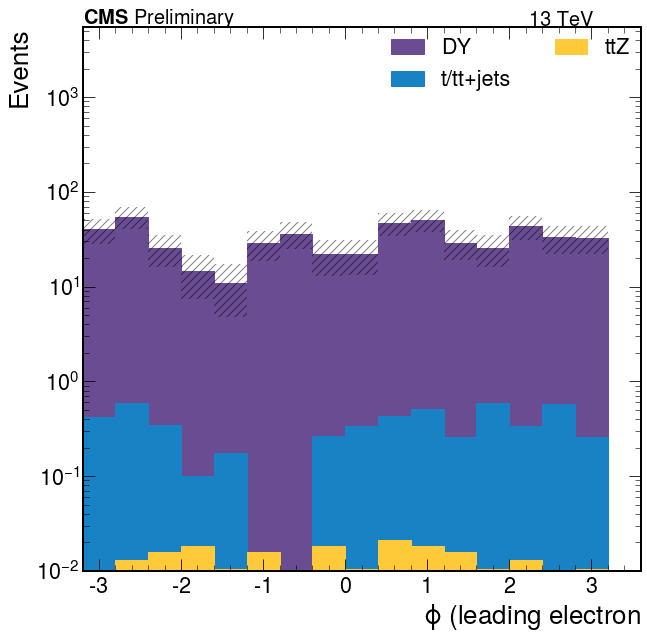

In [68]:
my_hist = scale_and_merge(output['flipped_electron'], samples, fileset, nano_mapping)

makePlot(my_hist, None, 'phi',
         data_sel=None,
         bins=phi_bins, log=True, normalize=False, axis_label=r'$\phi\ (leading\ electron$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
        )

ValueError: plot2d() can only support exactly two dimensions

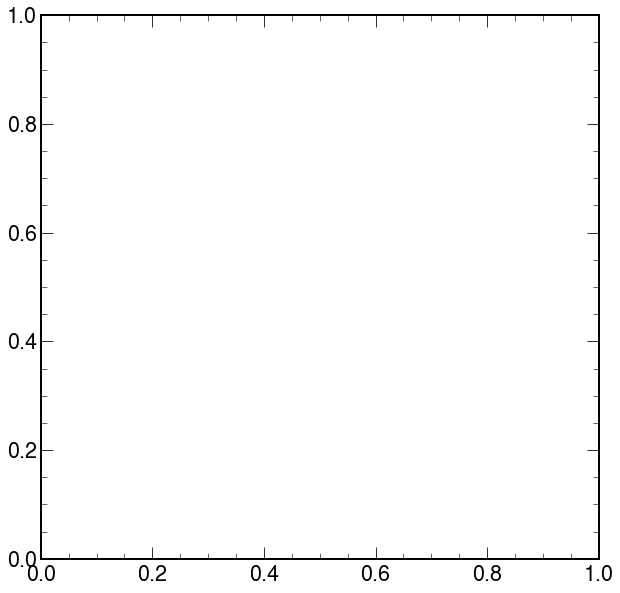

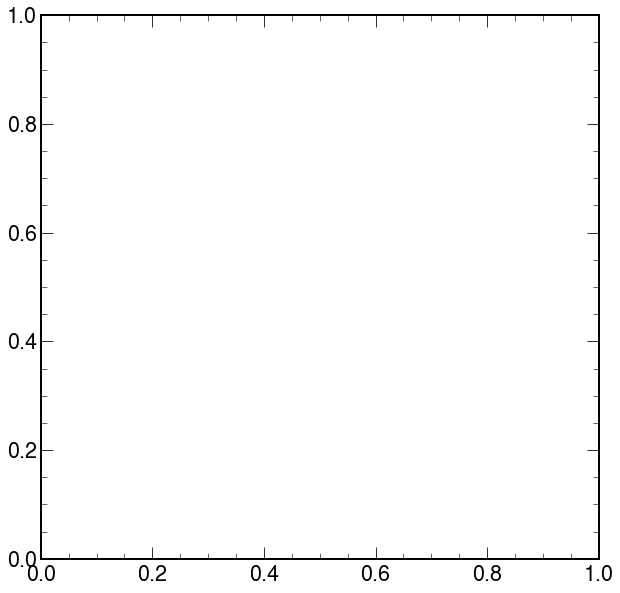

In [88]:
fig, ax  = plt.subplots(1,1,figsize=(10,10) )
ax = hist.plot2d(
    output['electron'].sum('dataset'),
    xaxis='pt',
    text_opts={'format': '%.3g'},
    patch_opts={},
)
ax.set_xlabel(r'$N_{charge flips}$')
ax.set_ylabel(r'$N_{nonprompt}$')